# Прогнозирование статуса студента

**Импорт библиотек**

In [866]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
%matplotlib inline

**Знакомство с датасетом**

In [867]:
df = pd.read_csv('train_dataset_train.csv')
df_test = pd.read_csv('test_dataset_test.csv')
df_submission = pd.read_csv('sample_submission.csv')

In [868]:
df_submission.head()

,ID,Статус
0,64996,NaN
1,71837,NaN
2,86587,NaN
3,73673,NaN
4,54709,NaN


In [869]:
df.head()

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
0,72716,16019,2015,Жен,ОО,Английский язык,1998-02-08 00:00:00.000,"МБОУ ""СОШ №59""","Алтайский край, Барнаул г",2014.0,...,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3
1,63306,14895,2010,Муж,ЦН,NaN,1992-04-18 00:00:00.000,NaN,NaN,NaN,...,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4
2,82469,20103,2017,Жен,ДН,Английский язык,1999-03-21 00:00:00.000,МБОУ Алтайская СОШ №5,"Алтайский край, Алтайский р-н, Алтайское с",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4
3,81661,19838,2017,Жен,БН,Английский язык,1994-12-08 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,35.0,74.000,4
4,81509,19803,2017,Жен,БН,Английский язык,1995-06-28 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,53.000,4


In [870]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13584 entries, 0 to 13583
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                13584 non-null  int64  
 1   Код_группы        13584 non-null  int64  
 2   Год_Поступления   13584 non-null  int64  
 3   Пол               13577 non-null  object 
 4   Основания         13584 non-null  object 
 5   Изучаемый_Язык    12758 non-null  object 
 6   Дата_Рождения     13584 non-null  object 
 7   Уч_Заведение      12351 non-null  object 
 8   Где_Находится_УЗ  12203 non-null  object 
 9   Год_Окончания_УЗ  12284 non-null  float64
 10  Пособие           12576 non-null  float64
 11  Страна_ПП         13237 non-null  object 
 12  Регион_ПП         12966 non-null  object 
 13  Город_ПП          13141 non-null  object 
 14  Общежитие         13498 non-null  float64
 15  Наличие_Матери    13584 non-null  int64  
 16  Наличие_Отца      13584 non-null  float6

In [871]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6691 entries, 0 to 6690
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                6691 non-null   int64  
 1   Код_группы        6691 non-null   int64  
 2   Год_Поступления   6691 non-null   int64  
 3   Пол               6688 non-null   object 
 4   Основания         6691 non-null   object 
 5   Изучаемый_Язык    6295 non-null   object 
 6   Дата_Рождения     6691 non-null   object 
 7   Уч_Заведение      6113 non-null   object 
 8   Где_Находится_УЗ  6031 non-null   object 
 9   Год_Окончания_УЗ  6074 non-null   float64
 10  Пособие           6207 non-null   float64
 11  Страна_ПП         6531 non-null   object 
 12  Регион_ПП         6401 non-null   object 
 13  Город_ПП          6477 non-null   object 
 14  Общежитие         6656 non-null   float64
 15  Наличие_Матери    6691 non-null   int64  
 16  Наличие_Отца      6691 non-null   float64


**Доли групп студентов с разным статусом (таргетом)**

In [872]:
df['Статус'].value_counts()

 4    8249
 3    4721
-1     614
Name: Статус, dtype: int64

In [873]:
df['Статус'].value_counts(normalize=True)

 4    0.607259
 3    0.347541
-1    0.045200
Name: Статус, dtype: float64

## Предобработка и исследовательский анализ

**Группы**

Посмотрим сколько уникальных групп в данных

In [874]:
len(df['Код_группы'].unique())

3653

In [875]:
len(df_test['Код_группы'].unique())

2677

Посмотрим каков размер групп

In [876]:
df.groupby('Код_группы')['ID'].agg('count').mean()

3.718587462359704

Для полноценных группа такое количество студентов малО, обрежем номера групп:

In [877]:
df['Код_группы'] = df['Код_группы'].astype('str').str.slice(0,4)

In [878]:
df.groupby('Код_группы')['ID'].agg('count').median()

8.0

In [879]:
df['Код_группы'] = df['Код_группы'].astype('int')

Посмотрим связь между номерами групп и статусом студентов:

In [880]:
df_group_status = df.pivot_table(index = 'Код_группы', columns = 'Статус', values = 'ID', aggfunc = ['count'])
df_group_status

count         
Статус        -1    3   4
Код_группы               
1155         NaN  2.0 NaN
1157         NaN  1.0 NaN
1159         NaN  2.0 NaN
1160         NaN  3.0 NaN
1161         NaN  1.0 NaN
...          ...  ...  ..
2275         2.0  2.0 NaN
2276         2.0  NaN NaN
2280         NaN  1.0 NaN
2281         NaN  1.0 NaN
2282         1.0  3.0 NaN

[835 rows x 3 columns]

In [881]:
df_group_status = df_group_status.fillna(0)

In [882]:
df_group_status.columns = ['-1', '3', '4']

**Пол**

In [883]:
df['Пол'].value_counts(normalize=True)

Жен    0.599028
Муж    0.400899
муж    0.000074
Name: Пол, dtype: float64

In [884]:
df['Пол'] = df['Пол'].str.lower()

Посмотрим связь между полом студента и его статусом

In [885]:
df.pivot_table(index = 'Пол', columns = 'Статус', values = 'ID', aggfunc = ['count'])

count            
Статус    -1     3     4
Пол                     
жен      270  2402  5461
муж      344  2315  2785

In [886]:
df['Пол']= df['Пол'].fillna('жен')

In [887]:
df_pol_status = df.pivot_table(index = 'Пол', columns = 'Статус', values = 'ID', aggfunc = ['count'])

In [888]:
df_pol_status.columns = ['-1', '3', '4']

In [889]:
df_pol_status['-1/sum']=df_pol_status['-1']/(df_pol_status['-1']+df_pol_status['3']+df_pol_status['4'])
df_pol_status['3/sum']=df_pol_status['3']/(df_pol_status['-1']+df_pol_status['3']+df_pol_status['4'])
df_pol_status

,-1,3,4,-1/sum,3/sum
Пол,,,,,
жен,270,2406,5464,0.033170,0.295577
муж,344,2315,2785,0.063189,0.425239


**Вывод**:
- мужчины чаще отчисляются и уходят в академ

In [890]:
def pol(sex):
    if sex == 'жен':
        return 0
    if sex == 'муж':
        return 1   

In [891]:
df['Пол']= df['Пол'].apply(pol)

**Год поступления**

Посмотрим связь между годом поступления и статусом

In [892]:
df.pivot_table(index = 'Год_Поступления', columns = 'Статус', values = 'ID', aggfunc = ['count'])

count               
Статус              -1      3       4
Год_Поступления                      
2001               NaN    1.0     NaN
2003               NaN    NaN     1.0
2004               NaN    1.0     NaN
2005               NaN    NaN     1.0
2007               NaN    NaN     5.0
2008               NaN    NaN     2.0
2009               NaN    3.0     5.0
2010               NaN    NaN    19.0
2011               NaN    4.0    42.0
2012               3.0  354.0  1037.0
2013              12.0  790.0  1268.0
2014              24.0  724.0  1542.0
2015              39.0  718.0  1596.0
2016              76.0  703.0  1492.0
2017             141.0  578.0   741.0
2018             149.0  501.0   497.0
2019             148.0  317.0     1.0
2020              22.0   26.0     NaN
2212               NaN    1.0     NaN

Обрежем аномалии:

In [893]:
df=df[df['Год_Поступления']<=2020]

In [894]:
df=df[df['Год_Поступления']>=2012]

Посмотрим взаимосвязь года поступления и статуса:

In [895]:
df_year_status = df.pivot_table(index = 'Год_Поступления', columns = 'Статус', values = 'ID', aggfunc = ['count'])

In [896]:
df_year_status.columns = ['-1', '3', '4']

In [897]:
df_year_status['-1/sum']=df_year_status['-1']/(df_year_status['-1']+df_year_status['3']+df_year_status['4'])
df_year_status['3/sum']=df_year_status['3']/(df_year_status['-1']+df_year_status['3']+df_year_status['4'])
df_year_status

,-1,3,4,-1/sum,3/sum
Год_Поступления,,,,,
2012,3.0,354.0,1037.0,0.002152,0.253945
2013,12.0,790.0,1268.0,0.005797,0.381643
2014,24.0,724.0,1542.0,0.010480,0.316157
2015,39.0,718.0,1596.0,0.016575,0.305142
2016,76.0,703.0,1492.0,0.033465,0.309555
2017,141.0,578.0,741.0,0.096575,0.395890
2018,149.0,501.0,497.0,0.129904,0.436792
2019,148.0,317.0,1.0,0.317597,0.680258
2020,22.0,26.0,NaN,NaN,NaN


**Вывод**:
- с годами, особенно после 2017 года растут доли ушедших в академ или отчисленных
- но это мнение может быть ошибочно, так как в статус закончивших обучение многие, кто поступал после 2017 могли не попасть
- то есть это ошибка статистики: фиксируются только ушедшие в академ или отчисленные, а те, то учится не попали в статистику

In [898]:
pd.crosstab(df['Год_Поступления'], df[df['Год_Окончания_УЗ']>2009]['Год_Окончания_УЗ'])

Год_Окончания_УЗ,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
Год_Поступления,,,,,,,,,,,
2012,23,34,330,0,0,0,0,1,1,0,0
2013,36,60,149,1375,0,0,0,0,0,0,0
2014,41,41,94,134,1665,0,0,0,0,0,0
2015,25,33,48,99,156,1803,0,0,0,0,0
2016,17,13,33,49,116,125,1791,0,0,0,0
2017,6,5,12,17,26,81,105,1107,0,0,0
2018,7,11,15,17,14,37,76,78,807,0,0
2019,3,5,4,5,9,10,18,34,41,312,0
2020,0,0,0,0,0,0,0,0,1,3,28


**Вывод**: то есть Год_Окончания_Уз - это год окончания предыдущего учебного заведения (до Алтайского университета)

**Дополнительный признак (типа курс учебы)**

Введем дополнительный признак

In [899]:
def kurs (year):
    if year < 2017:
        return 'zero'
    if year == 2017:
        return 'one'
    if year == 2018:
        return 'two'
    if year == 2019:
        return 'three'
    if year == 2020:
        return 'four'
    else:
        return 'н.д.'

In [900]:
df['kurs'] = df['Год_Поступления'].apply(kurs)

In [901]:
df['kurs'].value_counts()

zero     10378
one       1460
two       1147
three      466
four        48
Name: kurs, dtype: int64

Посмотрим взаимосвязь "курса" и статуса:

In [902]:
df_kurs_status = df.pivot_table(index = 'kurs', columns = 'Статус', values = 'ID', aggfunc = ['count'])

In [903]:
df_kurs_status.columns = ['-1', '3', '4']

In [904]:
df_kurs_status['-1/sum']=df_kurs_status['-1']/(df_kurs_status['-1']+df_kurs_status['3']+df_kurs_status['4'])
df_kurs_status['3/sum']=df_kurs_status['3']/(df_kurs_status['-1']+df_kurs_status['3']+df_kurs_status['4'])
df_kurs_status

,-1,3,4,-1/sum,3/sum
kurs,,,,,
four,22.0,26.0,NaN,NaN,NaN
one,141.0,578.0,741.0,0.096575,0.395890
three,148.0,317.0,1.0,0.317597,0.680258
two,149.0,501.0,497.0,0.129904,0.436792
zero,154.0,3289.0,6935.0,0.014839,0.316920


**Основания для учебы**

Пропусков в train и test нет

In [905]:
df['Основания'].value_counts()

ОО    5053
СН    4515
БН    1878
ДН    1850
ЦН     203
Name: Основания, dtype: int64

In [906]:
df_osnov_status = df.pivot_table(index = 'Основания', columns = 'Статус', values = 'ID', aggfunc = ['count'])
df_osnov_status

count            
Статус       -1     3     4
Основания                  
БН           43   258  1577
ДН           53   389  1408
ОО          265  2143  2645
СН          246  1886  2383
ЦН            7    35   161

In [907]:
df_osnov_status.columns = ['-1', '3', '4']

In [908]:
df_osnov_status['-1/sum']=df_osnov_status['-1']/(df_osnov_status['-1']+df_osnov_status['3']+df_osnov_status['4'])
df_osnov_status['3/sum']=df_osnov_status['3']/(df_osnov_status['-1']+df_osnov_status['3']+df_osnov_status['4'])
df_osnov_status

,-1,3,4,-1/sum,3/sum
Основания,,,,,
БН,43,258,1577,0.022897,0.137380
ДН,53,389,1408,0.028649,0.210270
ОО,265,2143,2645,0.052444,0.424104
СН,246,1886,2383,0.054485,0.417719
ЦН,7,35,161,0.034483,0.172414


In [909]:
pd.crosstab(df['Основания'], df['Статус'])

Статус,-1,3,4
Основания,,,
БН,43,258,1577
ДН,53,389,1408
ОО,265,2143,2645
СН,246,1886,2383
ЦН,7,35,161


● СН - специальный набор  
● ЦН - целевой набор  
● БН - бюджетный набор  
● ОО - общие основания  
● ДН - дополнительный прием

**Вывод:**
- поступившие на общих основаниях или спецнаборе чаще уходят в академ или отчисляются
- это важный фактор

**Изучаемый язык**

In [910]:
df['Изучаемый_Язык'].value_counts()

Английский язык                  10415
Немецкий язык                     2215
Французский язык                    54
Англиийский                         10
Иностранный язык (Английский)       10
Русский язык                        10
Иностранный язык (Немецкий)          4
Name: Изучаемый_Язык, dtype: int64

In [911]:
df_test['Изучаемый_Язык'].value_counts()

Английский язык                  5202
Немецкий язык                    1047
Французский язык                   28
Иностранный язык (Английский)       8
Англиийский                         8
Английский, немецкий языки          1
Русский язык                        1
Name: Изучаемый_Язык, dtype: int64

**Дата рождения**

In [912]:
df['Дата_Рождения'] = pd.to_datetime(df['Дата_Рождения'], format='%Y-%m-%d %H:%M:%S')

In [913]:
df['Возраст']=df['Год_Поступления'] - df['Дата_Рождения'].dt.year.astype('int')

In [914]:
df['Возраст'].describe()

count    13499.000000
mean        20.969257
std          5.379578
min          1.000000
25%         18.000000
50%         19.000000
75%         22.000000
max         71.000000
Name: Возраст, dtype: float64

In [915]:
df[df['Возраст']<12]

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус,kurs,Возраст
1470,70617,1579,2015,0,ДН,Немецкий язык,2013-03-16,"ФГБОУ ВПО ""Алтайский государственный техническ...","Алтайский край, Барнаул г",2015.0,...,0.0,Россия,0.0,1.0,0.0,25.0,57.0,3,zero,2
4870,49234,1186,2013,1,ОО,Английский язык,2012-06-26,"МБОУ ""СОШ №7"" г. Рубцовск",г. Барнаул Алтайский край,2012.0,...,0.0,Россия,0.0,0.0,0.0,27.0,68.0,3,zero,1


**Учебное заведение**

In [916]:
df['Уч_Заведение'].value_counts()

ФГБОУ ВО Алтайский государственный университет                                   1359
ФГБОУ ВПО "Алтайский государственный университет"                                1024
ФГБОУ ВПО Алтайский государственный университет                                   113
ФГБОУ ВО Алтайский государственный технический университет им. И.И. Ползунова      88
Алтайский государственный университет                                              79
                                                                                 ... 
средняя школа "Цзиньгань" провинции Цзянси                                          1
МКОУ "Каяушенская СОШ"                                                              1
ФГБОУ ВПО "Алтайский государственный аграрный  университет"                         1
КГБПОУ Славгородский педагогический колледж                                         1
АГУ СПО                                                                             1
Name: Уч_Заведение, Length: 3623, dtype: int64

Заполним пропуски и разобьем на категории

In [917]:
df['Уч_Заведение'] = df['Уч_Заведение'].fillna('н.д.')

In [918]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('универ')]['Уч_Заведение'].index]='университет'

C:\anaconda3\envs\ds_practicum_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [919]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('школ')]['Уч_Заведение'].index]='школа'

In [920]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('СОШ')]['Уч_Заведение'].index]='школа'

In [921]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('ОШ')]['Уч_Заведение'].index]='школа'

In [922]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('имнази')]['Уч_Заведение'].index]='гимназия'

In [923]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('ицей')]['Уч_Заведение'].index]='гимназия'

In [924]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('колледж')]['Уч_Заведение'].index]='колледж'

In [925]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('коллежд')]['Уч_Заведение'].index]='колледж'

In [926]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('Колледж')]['Уч_Заведение'].index]='колледж'

In [927]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('чилище')]['Уч_Заведение'].index]='училище'

In [928]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('нститут')]['Уч_Заведение'].index]='институт'

In [929]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('СШ')]['Уч_Заведение'].index]='школа'

In [930]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('демия')]['Уч_Заведение'].index]='академия'

In [931]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('ехникум')]['Уч_Заведение'].index]='техникум'

In [932]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('СОУ')]['Уч_Заведение'].index]='школа'

In [933]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('Универ')]['Уч_Заведение'].index]='университет'

In [934]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('Школа')]['Уч_Заведение'].index]='школа'

In [935]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('ФГБОУ')]['Уч_Заведение'].index]='университет'

In [936]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('фгбоу')]['Уч_Заведение'].index]='университет'

In [937]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('ФГОУ')]['Уч_Заведение'].index]='университет'

In [938]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('ГОУ')]['Уч_Заведение'].index]='университет'

In [939]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('фгоу')]['Уч_Заведение'].index]='университет'

In [940]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('МОУ')]['Уч_Заведение'].index]='школа'

In [941]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('моу')]['Уч_Заведение'].index]='школа'

In [942]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('СОМШ')]['Уч_Заведение'].index]='школа'

In [943]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('СОПШ')]['Уч_Заведение'].index]='школа'

In [944]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('СПТУ')]['Уч_Заведение'].index]='училище'

In [945]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('ПТУ')]['Уч_Заведение'].index]='училище'

In [946]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('ПУ')]['Уч_Заведение'].index]='училище'

In [947]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('АлтГУ')]['Уч_Заведение'].index]='университет'

In [948]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('АГАУ')]['Уч_Заведение'].index]='университет'

In [949]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('ВЗФ')]['Уч_Заведение'].index]='институт'

In [950]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('ФГКОУ')]['Уч_Заведение'].index]='институт'

In [951]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('Средн')]['Уч_Заведение'].index]='школа'

In [952]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('средн')]['Уч_Заведение'].index]='школа'

In [953]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('унив')]['Уч_Заведение'].index]='университет'

In [954]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('ГТУ')]['Уч_Заведение'].index]='университет'

In [955]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('КГБОУ')]['Уч_Заведение'].index]='колледж'

In [956]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('КГБПОУ')]['Уч_Заведение'].index]='колледж'

In [957]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('консерватор')]['Уч_Заведение'].index]='университет'

In [958]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('колледж')]['Уч_Заведение'].index]='колледж'

In [959]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('кадет')]['Уч_Заведение'].index]='кадет_корпус'

In [960]:
df['Уч_Заведение'].loc[df[df['Уч_Заведение'].str.contains('ГУ')]['Уч_Заведение'].index]='университет'

In [961]:
df['Уч_Заведение'].unique()

array(['школа', 'университет', 'н.д.', 'гимназия', 'академия', 'техникум',
       'колледж', 'училище',
       'Образовательное учреждение профсоюзов Академии труда и социальных отношений',
       'институт',
       'Образовательное учреждение профсоюзов ВПО "Академии труда и социальных отношений"',
       'ПЛ-39 г. Яровое', 'МБОУ Гимназяи №123', 'НОУ СГА',
       'Худжандский государственный уриверситет им. Академика Б. Гафурова',
       'кадет_корпус', 'МБОУ Гиназия 5', 'Бийская СПН №3',
       'НОУ ВПО "АЭЮИ"', 'МБОУ "Центр образования"',
       'Автономная некоммерческая обр-ная орг-ция ВО "ААЭиП"',
       'МБОУ "Центр образования села Лаврентия"', 'ООУ №57',
       'ФГКВОУ ВПО "ВА РХБЗ и  ИВ им. Маршала  СК Тимошенко"', 'СХТ',
       'Малышево-логовская', 'мбоу сош №10', 'мбоу сош №120',
       'НОУ ВПО МАП при Правительстве Москвы', 'УВК ШГ-№9', 'АТИВТ',
       'БЮИ МВД РФ', 'Общественно-гуманитарный уклон лицея Ага Хана',
       'АНО ВПО ААЭП', 'гу сш №3 им. Ю.А. Гагарина', 'АКП

In [962]:
education = ['школа', 'н.д.', 'университет', 'гимназия', 'академия', 'техникум',
       'колледж', 'училище','институт','кадет_корпус']

In [963]:
df['Уч_Заведение'].loc[df[~df['Уч_Заведение'].isin(education)]['Уч_Заведение'].index]='иное'

Вот итог разбивки на категории:

In [964]:
df['Уч_Заведение'].value_counts()

школа           4783
университет     3956
гимназия        2081
н.д.            1177
колледж          602
академия         333
техникум         207
институт         188
училище          134
иное              27
кадет_корпус      11
Name: Уч_Заведение, dtype: int64

Посмотрим связь между категорией учебного заведения и статусом

In [965]:
df_educ_status = df.pivot_table(index = 'Уч_Заведение', columns = 'Статус', values = 'ID', aggfunc = ['count'])
df_educ_status

count                
Статус           -1       3       4
Уч_Заведение                       
академия       20.0   110.0   203.0
гимназия      113.0   711.0  1257.0
иное            NaN    13.0    14.0
институт        4.0    65.0   119.0
кадет_корпус    1.0     5.0     5.0
колледж        23.0   327.0   252.0
н.д.            2.0   257.0   918.0
техникум        8.0    94.0   105.0
университет   186.0  1305.0  2465.0
училище         4.0    80.0    50.0
школа         253.0  1744.0  2786.0

In [966]:
df_educ_status.columns = ['-1', '3', '4']

In [967]:
df_educ_status = df_educ_status.fillna(0)

In [968]:
df_educ_status['-1/sum']=df_educ_status['-1']/(df_educ_status['-1']+df_educ_status['3']+df_educ_status['4'])
df_educ_status['3/sum']=df_educ_status['3']/(df_educ_status['-1']+df_educ_status['3']+df_educ_status['4'])
df_educ_status

,-1,3,4,-1/sum,3/sum
Уч_Заведение,,,,,
академия,20.0,110.0,203.0,0.060060,0.330330
гимназия,113.0,711.0,1257.0,0.054301,0.341663
иное,0.0,13.0,14.0,0.000000,0.481481
институт,4.0,65.0,119.0,0.021277,0.345745
кадет_корпус,1.0,5.0,5.0,0.090909,0.454545
колледж,23.0,327.0,252.0,0.038206,0.543189
н.д.,2.0,257.0,918.0,0.001699,0.218352
техникум,8.0,94.0,105.0,0.038647,0.454106
университет,186.0,1305.0,2465.0,0.047017,0.329879


In [969]:
pd.crosstab(df['Иностранец'], df['Уч_Заведение'])

Уч_Заведение,академия,гимназия,иное,институт,кадет_корпус,колледж,н.д.,техникум,университет,училище,школа
Иностранец,,,,,,,,,,,
0.0,303,1965,20,149,11,526,1112,198,3624,125,4228
1.0,12,95,4,22,0,50,24,5,212,4,508


**Вывод**:
- больше всего отчисляются закончившие колледж/техникум/училище/иное/кадетский_корпус
- меньше всего уходят в академ или отчисляются из группы "н.д."

**Пособие**

In [970]:
df['Пособие'].value_counts()

0.0    12499
Name: Пособие, dtype: int64

In [971]:
df['Пособие'] = df['Пособие'].fillna('1')

In [972]:
pd.crosstab(df['Пособие'], df['Статус'])

Статус,-1,3,4
Пособие,,,
0.0,600,4047,7852
1,14,664,322


**Вывод**:
- в пропусках по пособиям доля отчисленных выше.

**Общежитие**

In [973]:
df['Общежитие'].value_counts()

0.0    10455
1.0     2966
Name: Общежитие, dtype: int64

In [974]:
df['Общежитие'] = df['Общежитие'].fillna('2')

In [975]:
pd.crosstab(df['Общежитие'], df['Статус'])

Статус,-1,3,4
Общежитие,,,
0.0,452,3553,6450
1.0,162,1112,1692
2,0,46,32


In [976]:
df_home_status = df.pivot_table(index = 'Общежитие', columns = 'Статус', values = 'ID', aggfunc = ['count'])
df_home_status

count                
Статус        -1       3       4
Общежитие                       
0.0        452.0  3553.0  6450.0
1.0        162.0  1112.0  1692.0
2            NaN    46.0    32.0

In [977]:
df_home_status.columns = ['-1', '3', '4']

In [978]:
df_home_status = df_home_status.fillna(0)

In [979]:
df_home_status['-1/sum']=df_home_status['-1']/(df_home_status['-1']+df_home_status['3']+df_home_status['4'])
df_home_status['3/sum']=df_home_status['3']/(df_home_status['-1']+df_home_status['3']+df_home_status['4'])
df_home_status

,-1,3,4,-1/sum,3/sum
Общежитие,,,,,
0.0,452.0,3553.0,6450.0,0.043233,0.339837
1.0,162.0,1112.0,1692.0,0.054619,0.374916
2,0.0,46.0,32.0,0.000000,0.589744


**Вывод**:
- наличие общежития не влияет на статус

**Наличие родителей**

In [980]:
df['Наличие_Матери'].value_counts()

1    6863
0    6636
Name: Наличие_Матери, dtype: int64

In [981]:
df_mother_status = df.pivot_table(index = 'Наличие_Матери', columns = 'Статус', values = 'ID', aggfunc = ['count'])
df_mother_status

count            
Статус            -1     3     4
Наличие_Матери                  
0                238  2410  3988
1                376  2301  4186

In [982]:
df_mother_status.columns = ['-1', '3', '4']

In [983]:
df_mother_status['-1/sum']=df_mother_status['-1']/(df_mother_status['-1']+df_mother_status['3']+df_mother_status['4'])
df_mother_status['3/sum']=df_mother_status['3']/(df_mother_status['-1']+df_mother_status['3']+df_mother_status['4'])
df_mother_status

,-1,3,4,-1/sum,3/sum
Наличие_Матери,,,,,
0,238,2410,3988,0.035865,0.363171
1,376,2301,4186,0.054787,0.335276


In [984]:
df['Наличие_Отца'].value_counts()

1.0    6837
0.0    6662
Name: Наличие_Отца, dtype: int64

In [985]:
df_father_status = df.pivot_table(index = 'Наличие_Отца', columns = 'Статус', values = 'ID', aggfunc = ['count'])
df_father_status

count            
Статус          -1     3     4
Наличие_Отца                  
0.0            238  2413  4011
1.0            376  2298  4163

In [986]:
df_father_status.columns = ['-1', '3', '4']

In [987]:
df_father_status['-1/sum']=df_father_status['-1']/(df_father_status['-1']+df_father_status['3']+df_father_status['4'])
df_father_status['3/sum']=df_father_status['3']/(df_father_status['-1']+df_father_status['3']+df_father_status['4'])
df_father_status

,-1,3,4,-1/sum,3/sum
Наличие_Отца,,,,,
0.0,238,2413,4011,0.035725,0.362204
1.0,376,2298,4163,0.054995,0.336112


In [988]:
df['Опекунство'].value_counts()

0.0    13493
1.0        6
Name: Опекунство, dtype: int64

In [989]:
df_guard_status = df.pivot_table(index = 'Опекунство', columns = 'Статус', values = 'ID', aggfunc = ['count'])
df_guard_status

count            
Статус        -1     3     4
Опекунство                  
0.0          612  4708  8173
1.0            2     3     1

In [990]:
df_guard_status.columns = ['-1', '3', '4']

In [991]:
df_guard_status['-1/sum']=df_guard_status['-1']/(df_guard_status['-1']+df_guard_status['3']+df_guard_status['4'])
df_guard_status['3/sum']=df_guard_status['3']/(df_guard_status['-1']+df_guard_status['3']+df_guard_status['4'])
df_guard_status

,-1,3,4,-1/sum,3/sum
Опекунство,,,,,
0.0,612,4708,8173,0.045357,0.348922
1.0,2,3,1,0.333333,0.500000


**Выводы**:
- ученики с опекой гораздо чаще отчисляются и уходят в академ
- непонятно, почему достаточно много учников без матери или отца (может фиксировали не всех). В целом ученики без матери или отца чуть чаще (на 3%) отчисляются, но чуть реже уходят в академ.

**Страна_Родители**

In [992]:
df['Страна_Родители'] = df['Страна_Родители'].fillna('н.д.')

In [993]:
df['Страна_Родители'].value_counts()

Россия                    12182
Казахстан                   514
н.д.                        430
Китай                       147
Таджикистан                 133
Кыргызстан                   37
Киргизия                     31
Туркменистан                  5
Армения                       3
Узбекистан                    3
Кыргызская Республика         3
Монголия                      2
Республика Таджикистан        2
Нигерия                       1
КНР                           1
Республика Молдова            1
Республика Казахстан          1
Украина                       1
Германия                      1
казахстан                     1
Name: Страна_Родители, dtype: int64

Обработаем повторы и неправильные наименования

In [994]:
df['Страна_Родители'].loc[df[df['Страна_Родители'].str.contains('азахстан')]['Страна_Родители'].index]='Казахстан'

C:\anaconda3\envs\ds_practicum_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [995]:
df['Страна_Родители'].loc[df[df['Страна_Родители'].str.contains('аджикист')]['Страна_Родители'].index]='Таджикистан'

In [996]:
df['Страна_Родители'].loc[df[df['Страна_Родители'].str.contains('Киргиз')]['Страна_Родители'].index]='Кыргызстан'

In [997]:
df['Страна_Родители'].loc[df[df['Страна_Родители'].str.contains('Кыргыз')]['Страна_Родители'].index]='Кыргызстан'

In [998]:
df['Страна_Родители'].loc[df[df['Страна_Родители'].str.contains('КНР')]['Страна_Родители'].index]='Китай'

In [999]:
df['Страна_Родители'].value_counts()

Россия                12182
Казахстан               516
н.д.                    430
Китай                   148
Таджикистан             135
Кыргызстан               71
Туркменистан              5
Армения                   3
Узбекистан                3
Монголия                  2
Нигерия                   1
Германия                  1
Украина                   1
Республика Молдова        1
Name: Страна_Родители, dtype: int64

In [1000]:
df_country_status = df.pivot_table(index = 'Страна_Родители', columns = 'Статус', values = 'ID', aggfunc = ['count'])
df_country_status

count                
Статус                 -1       3       4
Страна_Родители                          
Армения               NaN     2.0     1.0
Германия              NaN     NaN     1.0
Казахстан            39.0   238.0   239.0
Китай                 NaN    86.0    62.0
Кыргызстан            7.0    32.0    32.0
Монголия              NaN     2.0     NaN
Нигерия               NaN     1.0     NaN
Республика Молдова    NaN     1.0     NaN
Россия              534.0  4111.0  7537.0
Таджикистан          17.0    57.0    61.0
Туркменистан          NaN     2.0     3.0
Узбекистан            NaN     NaN     3.0
Украина               NaN     1.0     NaN
н.д.                 17.0   178.0   235.0

In [1001]:
df_country_status.columns = ['-1', '3', '4']

In [1002]:
df_country_status = df_country_status.fillna(0)

In [1003]:
df_country_status['-1/sum']=df_country_status['-1']/(df_country_status['-1']+df_country_status['3']+df_country_status['4'])
df_country_status['3/sum']=df_country_status['3']/(df_country_status['-1']+df_country_status['3']+df_country_status['4'])
df_country_status

,-1,3,4,-1/sum,3/sum
Страна_Родители,,,,,
Армения,0.0,2.0,1.0,0.000000,0.666667
Германия,0.0,0.0,1.0,0.000000,0.000000
Казахстан,39.0,238.0,239.0,0.075581,0.461240
Китай,0.0,86.0,62.0,0.000000,0.581081
Кыргызстан,7.0,32.0,32.0,0.098592,0.450704
Монголия,0.0,2.0,0.0,0.000000,1.000000
Нигерия,0.0,1.0,0.0,0.000000,1.000000
Республика Молдова,0.0,1.0,0.0,0.000000,1.000000
Россия,534.0,4111.0,7537.0,0.043835,0.337465


In [1004]:
pd.crosstab(df['Иностранец'], df['Страна_Родители'])

Страна_Родители,Армения,Германия,Казахстан,Китай,Кыргызстан,Монголия,Нигерия,Республика Молдова,Россия,Таджикистан,Туркменистан,Узбекистан,Украина,н.д.
Иностранец,,,,,,,,,,,,,,
0.0,2,1,86,0,4,0,0,0,11811,7,0,0,0,350
1.0,1,0,428,148,66,2,1,1,148,128,5,3,1,4


In [1005]:
def country(b):
    if b == 'Россия':
        return 'Россия'
    if b == 'Казахстан':
        return 'Академ'
    if b == 'Кыргызстан':
        return 'Академ'
    if b == 'Таджикистан':
        return 'Академ'
    if b == 'Туркменистан':
        return 'Академ'
    if b == 'Узбекистан':
        return 'Академ'
    else:
        return 'Не академ'    

In [1006]:
df['Страна_Родители'] = df['Страна_Родители'].apply(country)

**Вывод**:
- если родители живут не в России, ученики чаще отчисляются

**Иностранец**

In [1007]:
df['Иностранец'] = df['Иностранец'].fillna('2')

In [1008]:
df['Иностранец'].value_counts()

0.0    12261
1.0      936
2        302
Name: Иностранец, dtype: int64

In [1009]:
df_ino_status = df.pivot_table(index = 'Иностранец', columns = 'Статус', values = 'ID', aggfunc = ['count'])
df_ino_status

count                
Статус         -1       3       4
Иностранец                       
0.0         535.0  4072.0  7654.0
1.0          79.0   447.0   410.0
2             NaN   192.0   110.0

In [1010]:
df_ino_status.columns = ['-1', '3', '4']

In [1011]:
df_ino_status = df_ino_status.fillna(0)

In [1012]:
df_ino_status['-1/sum']=df_ino_status['-1']/(df_ino_status['-1']+df_ino_status['3']+df_ino_status['4'])
df_ino_status['3/sum']=df_ino_status['3']/(df_ino_status['-1']+df_ino_status['3']+df_ino_status['4'])
df_ino_status

,-1,3,4,-1/sum,3/sum
Иностранец,,,,,
0.0,535.0,4072.0,7654.0,0.043634,0.332110
1.0,79.0,447.0,410.0,0.084402,0.477564
2,0.0,192.0,110.0,0.000000,0.635762


**Вывод**
- инострнцы и ученики с "н.д." чаще отчисляются
- но ученики с "н.д." не уходят в академ

In [1013]:
df['Иностранец']=df['Иностранец'].astype('str')

**Село**

In [1014]:
df['Село'] = df['Село'].fillna('2')

In [1015]:
df['Село'].value_counts()

0.0    10337
1.0     3084
2         78
Name: Село, dtype: int64

In [1016]:
df_selo_status = df.pivot_table(index = 'Село', columns = 'Статус', values = 'ID', aggfunc = ['count'])
df_selo_status

count                
Статус     -1       3       4
Село                         
0.0     504.0  3535.0  6298.0
1.0     110.0  1130.0  1844.0
2         NaN    46.0    32.0

In [1017]:
df_selo_status.columns = ['-1', '3', '4']

In [1018]:
df_selo_status = df_selo_status.fillna(0)

In [1019]:
df_selo_status['-1/sum']=df_selo_status['-1']/(df_selo_status['-1']+df_selo_status['3']+df_selo_status['4'])
df_selo_status['3/sum']=df_selo_status['3']/(df_selo_status['-1']+df_selo_status['3']+df_selo_status['4'])
df_selo_status

,-1,3,4,-1/sum,3/sum
Село,,,,,
0.0,504.0,3535.0,6298.0,0.048757,0.341975
1.0,110.0,1130.0,1844.0,0.035668,0.366407
2,0.0,46.0,32.0,0.000000,0.589744


**Вывод**
- фактор села не оказывает влияния,
- высокая отчисляемость для студентов, где "н.д."

**Код факультета**

In [1020]:
df['КодФакультета'].value_counts()

26.0    2759
25.0    2158
41.0    1485
51.0    1096
34.0     956
24.0     688
27.0     675
28.0     659
31.0     619
35.0     538
40.0     467
36.0     443
30.0     430
48.0     234
45.0      90
47.0      84
49.0      76
46.0      26
53.0      15
37.0       1
Name: КодФакультета, dtype: int64

In [1021]:
df_cod_status = df.pivot_table(index = 'КодФакультета', columns = 'Статус', values = 'ID', aggfunc = ['count'])
df_cod_status

count               
Статус           -1      3       4
КодФакультета                     
24.0           61.0  167.0   460.0
25.0           66.0  594.0  1498.0
26.0           79.0  858.0  1822.0
27.0           28.0  410.0   237.0
28.0           20.0  331.0   308.0
30.0           54.0   99.0   277.0
31.0           21.0  228.0   370.0
34.0           74.0  320.0   562.0
35.0           16.0  130.0   392.0
36.0           30.0  152.0   261.0
37.0            NaN    1.0     NaN
40.0           19.0  174.0   274.0
41.0           65.0  569.0   851.0
45.0            1.0   56.0    33.0
46.0            4.0   21.0     1.0
47.0            NaN   35.0    49.0
48.0           10.0  108.0   116.0
49.0            2.0   34.0    40.0
51.0           61.0  416.0   619.0
53.0            3.0    8.0     4.0

In [1022]:
df_cod_status = df_cod_status.fillna(0)

In [1023]:
df_cod_status.columns = ['-1', '3', '4']

In [1024]:
df_cod_status['-1/sum']=df_cod_status['-1']/(df_cod_status['-1']+df_cod_status['3']+df_cod_status['4'])

In [1025]:
df_cod_status['3/sum']=df_cod_status['3']/(df_cod_status['-1']+df_cod_status['3']+df_cod_status['4'])

In [1026]:
df_cod_status

,-1,3,4,-1/sum,3/sum
КодФакультета,,,,,
24.0,61.0,167.0,460.0,0.088663,0.242733
25.0,66.0,594.0,1498.0,0.030584,0.275255
26.0,79.0,858.0,1822.0,0.028634,0.310982
27.0,28.0,410.0,237.0,0.041481,0.607407
28.0,20.0,331.0,308.0,0.030349,0.502276
30.0,54.0,99.0,277.0,0.125581,0.230233
31.0,21.0,228.0,370.0,0.033926,0.368336
34.0,74.0,320.0,562.0,0.077406,0.334728
35.0,16.0,130.0,392.0,0.029740,0.241636


**Вывод**
- есть факультеты с высокой отчисляемостью ()
- есть факультеты, наоборот, с низкой отчисляемостью ()

In [1027]:
df['КодФакультета'] = df['КодФакультета'].astype('str')

**Балл аттестата**

In [1028]:
df[df['СрБаллАттестата']==0]['СрБаллАттестата'].count()

10

In [1029]:
df[df['СрБаллАттестата']<=5]['СрБаллАттестата'].mean()

4.123663995354239

In [1030]:
def ball_group(temp):
    if temp < 3:
        return '01'
    if temp < 3.5:
        return '02'
    if temp < 4:
        return '03'
    if temp < 4.5:
        return '04'
    if temp <= 5:
        return '05'
    if temp < 60:
        return '01'
    if temp < 70:
        return '02'
    if temp < 80:
        return '03'
    if temp < 90:
        return '04'
    if temp <= 100:
        return '05'
    else:
        return '00'

In [1031]:
def ball_group_gross(temp):
    if temp < 3:
        return '01'
    if temp < 3.25:
        return '02'
    if temp < 3.5:
        return '03'
    if temp < 3.75:
        return '04'
    if temp < 4:
        return '05'
    if temp < 4.25:
        return '06'
    if temp < 4.5:
        return '07'
    if temp < 4.75:
        return '08'
    if temp <= 5:
        return '09'
    if temp < 35:
        return '01'
    if temp < 40:
        return '02'
    if temp < 45:
        return '03'
    if temp < 50:
        return '04'
    if temp < 55:
        return '05'
    if temp < 60:
        return '06'
    if temp < 65:
        return '07'
    if temp < 70:
        return '08'
    if temp <= 100:
        return '09'
    else:
        return '00'

In [1032]:
df['ball_group']=df['СрБаллАттестата'].apply(ball_group_gross)

In [1033]:
df_ball_status = df.pivot_table(index = 'ball_group', columns = 'Статус', values = 'ID', aggfunc = ['count'])
df_ball_status

count            
Статус        -1     3     4
ball_group                  
00             8    34    10
01             6    76   151
02             8   182   188
03            28   437   384
04            57   553   540
05            67   577   790
06            92   621   846
07            98   544   959
08            70   452   869
09           180  1235  3437

In [1034]:
df_ball_status = df_ball_status.fillna(0)

In [1035]:
df_ball_status.columns = ['-1', '3', '4']

In [1036]:
df_ball_status['-1/sum']=df_ball_status['-1']/(df_ball_status['-1']+df_ball_status['3']+df_ball_status['4'])

In [1037]:
df_ball_status['3/sum']=df_ball_status['3']/(df_ball_status['-1']+df_ball_status['3']+df_ball_status['4'])

In [1038]:
df_ball_status

,-1,3,4,-1/sum,3/sum
ball_group,,,,,
00,8,34,10,0.153846,0.653846
01,6,76,151,0.025751,0.326180
02,8,182,188,0.021164,0.481481
03,28,437,384,0.032980,0.514723
04,57,553,540,0.049565,0.480870
05,67,577,790,0.046722,0.402371
06,92,621,846,0.059012,0.398332
07,98,544,959,0.061212,0.339788
08,70,452,869,0.050324,0.324946


**Город_ПП**

In [1039]:
df['Город_ПП']=df['Город_ПП'].fillna('н.д.')

In [1040]:
df['Город_ПП'].loc[df[df['Город_ПП'].str.contains('Барнаул')]['Город_ПП'].index]='Барнаул'

C:\anaconda3\envs\ds_practicum_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [1041]:
town = ['Барнаул']

In [1042]:
df['Город_ПП'].loc[df[~df['Город_ПП'].isin(town)]['Город_ПП'].index]=1

In [1043]:
df['Город_ПП'].value_counts()

Барнаул    6832
1          6667
Name: Город_ПП, dtype: int64

In [1044]:
def town(c):
    if c =='Барнаул':
        return 0
    else:
        return 1

In [1045]:
df['Город_ПП']=df['Город_ПП'].apply(town)

In [1046]:
df['Город_ПП'].value_counts()

0    6832
1    6667
Name: Город_ПП, dtype: int64

In [1047]:
df_town_status = df.pivot_table(index = 'Город_ПП', columns = 'Статус', values = 'ID', aggfunc = ['count'])

In [1048]:
df_town_status.columns = ['-1', '3', '4']

In [1049]:
df_town_status['-1/sum']=df_town_status['-1']/(df_town_status['-1']+df_town_status['3']+df_town_status['4'])
df_town_status['3/sum']=df_town_status['3']/(df_town_status['-1']+df_town_status['3']+df_town_status['4'])
df_town_status

,-1,3,4,-1/sum,3/sum
Город_ПП,,,,,
0,325,2073,4434,0.047570,0.303425
1,289,2638,3740,0.043348,0.395680


**Подготовка столбцов к разделению на train/test**

In [1050]:
df.columns

Index(['ID', 'Код_группы', 'Год_Поступления', 'Пол', 'Основания',
       'Изучаемый_Язык', 'Дата_Рождения', 'Уч_Заведение', 'Где_Находится_УЗ',
       'Год_Окончания_УЗ', 'Пособие', 'Страна_ПП', 'Регион_ПП', 'Город_ПП',
       'Общежитие', 'Наличие_Матери', 'Наличие_Отца', 'Страна_Родители',
       'Опекунство', 'Село', 'Иностранец', 'КодФакультета', 'СрБаллАттестата',
       'Статус', 'kurs', 'Возраст', 'ball_group'],
      dtype='object')

In [1051]:
columns_to_drop = ['ID','Год_Окончания_УЗ',
       'Изучаемый_Язык', 'Дата_Рождения', 'Где_Находится_УЗ',
       'Страна_ПП', 'Регион_ПП', 'СрБаллАттестата', 'Иностранец']

In [1052]:
df = df.drop(columns = columns_to_drop, axis=1)

In [1053]:
df.columns

Index(['Код_группы', 'Год_Поступления', 'Пол', 'Основания', 'Уч_Заведение',
       'Пособие', 'Город_ПП', 'Общежитие', 'Наличие_Матери', 'Наличие_Отца',
       'Страна_Родители', 'Опекунство', 'Село', 'КодФакультета', 'Статус',
       'kurs', 'Возраст', 'ball_group'],
      dtype='object')

In [1054]:
df['ball_group']=df['ball_group'].astype('str')

In [1055]:
col_int = ['Пособие','Общежитие','Село']

In [1056]:
df[col_int]= df[col_int].astype('int')

In [1057]:
df = pd.get_dummies(df, drop_first=True)

In [1058]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13499 entries, 0 to 13583
Data columns (total 60 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Код_группы                 13499 non-null  int32  
 1   Год_Поступления            13499 non-null  int64  
 2   Пол                        13499 non-null  int64  
 3   Пособие                    13499 non-null  int32  
 4   Город_ПП                   13499 non-null  int64  
 5   Общежитие                  13499 non-null  int32  
 6   Наличие_Матери             13499 non-null  int64  
 7   Наличие_Отца               13499 non-null  float64
 8   Опекунство                 13499 non-null  float64
 9   Село                       13499 non-null  int32  
 10  Статус                     13499 non-null  int64  
 11  Возраст                    13499 non-null  int64  
 12  Основания_ДН               13499 non-null  uint8  
 13  Основания_ОО               13499 non-null  uin

**Деление выборки на train / test**

In [1059]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns = ['Статус'], axis=1), df['Статус'], stratify = df['Статус'], test_size=0.1, random_state=20220902)

In [1060]:
print(X_train.shape)
print(y_train.shape)

(12149, 59)
(12149,)


**Light GBM**

In [1061]:
lgbm = LGBMClassifier(learning_rate = 0.1, boosting_type = 'gbdt', max_depth=20)

In [1062]:
parameters_lgbm = {'max_depth': [10, 20, 30, 40],
                  'learning_rate':[0.1, 0.15, 0.5, 1]}

In [1063]:
#lgbm = GridSearchCV(lgbm, parameters_lgbm)

In [1064]:
%%time
#lgbm.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [1065]:
#lgbm.best_params_

In [1066]:
#pred_1 = lgbm.predict(X_test)

In [1067]:
#f1_score(y_test, pred_1, average='macro', zero_division = 0)

In [1068]:
#pred = lgbm.predict(X_train)

In [1069]:
#f1_score(y_train, pred, average='macro', zero_division = 0)

In [1070]:
#print(classification_report(y_test, pred_1))

In [1071]:
cat = CatBoostClassifier(boosting_type = 'Ordered', learning_rate = 0.1, depth= 10, l2_leaf_reg = 2, random_state=0, verbose = False)

In [1072]:
#CatBoostClassifier(boosting_type = 'Ordered', learning_rate = 0.1, depth= 10, l2_leaf_reg = 2, random_state=0, verbose = False)

In [1073]:
#parameters_cat = {'learning_rate': [0.01, 0.03, 0.1, 0.15, 0.3],
#                 'depth': [3, 6, 12],
#                'l2_leaf_reg': [1, 5]}
        
    #'depth': [3, 6, 12],
        #'l2_leaf_reg': [1, 5]}

In [1074]:
#cat = GridSearchCV(cat, parameters_cat)

In [1075]:
%%time
cat.fit(X_train, y_train)

CPU times: total: 8min 38s
Wall time: 2min 58s


In [1076]:
#cat.best_params_

In [1077]:
pred_2 = cat.predict(X_test)

In [1078]:
f1_score(y_test, pred_2, average='macro', zero_division = 0)

0.800486663133722

In [1079]:
print(classification_report(y_test, pred_2))

              precision    recall  f1-score   support

          -1       0.69      0.57      0.62        61
           3       0.90      0.79      0.84       471
           4       0.90      0.97      0.93       818

    accuracy                           0.89      1350
   macro avg       0.83      0.78      0.80      1350
weighted avg       0.89      0.89      0.89      1350



In [1080]:
coef = pd.DataFrame({'features': X_train.columns, 
                     'coef' :np.around(cat.feature_importances_, decimals=2)
                    })
coef

,features,coef
0,Код_группы,30.80
1,Год_Поступления,11.02
2,Пол,2.22
3,Пособие,1.32
4,Город_ПП,1.07
5,Общежитие,0.83
6,Наличие_Матери,0.85
7,Наличие_Отца,0.46
8,Опекунство,0.00
9,Село,0.66


Text(0, 0.5, 'Важность в модели Catboost')

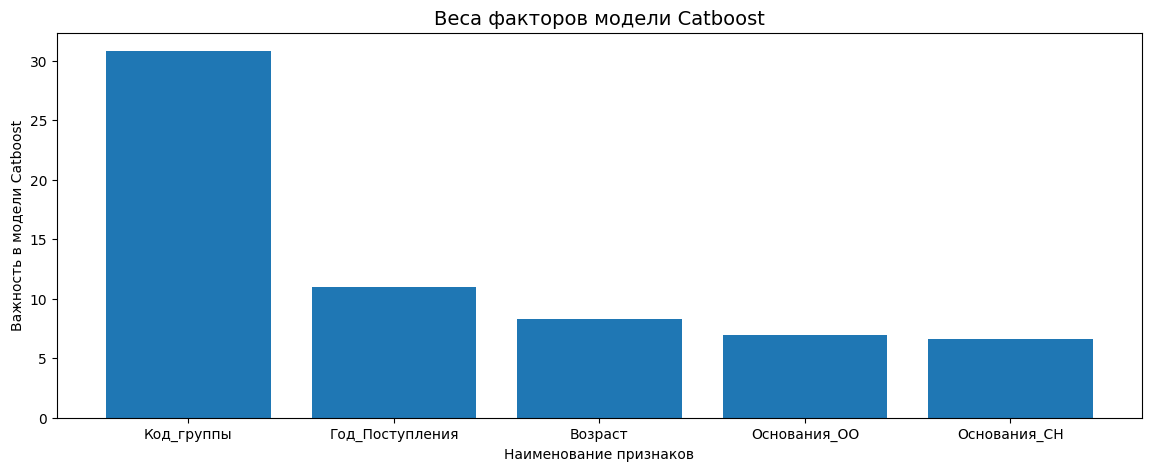

In [1081]:
coef = coef.loc[coef['coef']>5]
plt.figure(figsize = (14,5))
plt.bar(x = coef['features'], height = coef['coef'])
plt.title('Веса факторов модели Catboost', fontsize = 14)
plt.xlabel('Наименование признаков')
plt.ylabel('Важность в модели Catboost')

In [1082]:
clf = RandomForestClassifier(random_state=0)

In [1083]:
%%time
clf.fit(X_train, y_train)

CPU times: total: 1.02 s
Wall time: 1.02 s


RandomForestClassifier(random_state=0)

In [1084]:
pred_3 = clf.predict(X_test)

In [1085]:
f1_score(y_test, pred_3, average='macro', zero_division = 0)

0.7484744949848064

In [1086]:
print(classification_report(y_test, pred_3))

              precision    recall  f1-score   support

          -1       0.76      0.41      0.53        61
           3       0.87      0.75      0.80       471
           4       0.87      0.96      0.91       818

    accuracy                           0.86      1350
   macro avg       0.83      0.71      0.75      1350
weighted avg       0.86      0.86      0.86      1350



**Вывод**:
- бустинги показали схожие результаты
- случайный лес оказался хуже
- исходя из размера метрики на тестовой выборке выбираем модель Catboost

**Операции с тестовой выборкой**

Проведем аналогичные операции (как с обучающей) с тестовой выборкой

In [1087]:
df_test = pd.read_csv('test_dataset_test.csv')

In [1088]:
df_submission["ID"]=df_test['ID']

In [1089]:
df_test.head()

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Город_ПП,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата
0,64996,20608,2014,Жен,ДН,Английский язык,1995-11-03 00:00:00.000,"МБОУ ""СОШ №55""","Алтайский край, Барнаул г",2014.0,...,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,40.0,49.0
1,71837,20613,2015,Жен,ДН,Немецкий язык,1995-12-10 00:00:00.000,"МБОУ ""СОШ №1""","Алтайский край, Рубцовск г",2014.0,...,Барнаул г,0.0,0,0.0,Россия,0.0,1.0,0.0,26.0,77.0
2,86587,21210,2018,Жен,ОО,Английский язык,1973-08-09 00:00:00.000,Алтайский государственный медицинский университет,"Алтайский край, г. Барнаул",1997.0,...,г. Барнаул,0.0,1,1.0,Россия,0.0,0.0,0.0,34.0,74.0
3,73673,22254,2015,Жен,ОО,Английский язык,1983-12-07 00:00:00.000,"ГОУ ВПО ""Алтайский государственный университет""","Алтайский край, Барнаул г",2006.0,...,Барнаул г,0.0,0,0.0,Россия,0.0,0.0,0.0,53.0,57.0
4,54709,15040,2012,Жен,ОО,NaN,1994-05-21 00:00:00.000,NaN,NaN,NaN,...,NaN,0.0,1,1.0,Россия,0.0,0.0,0.0,36.0,55.0


In [1090]:
df_test.columns

Index(['ID', 'Код_группы', 'Год_Поступления', 'Пол', 'Основания',
       'Изучаемый_Язык', 'Дата_Рождения', 'Уч_Заведение', 'Где_Находится_УЗ',
       'Год_Окончания_УЗ', 'Пособие', 'Страна_ПП', 'Регион_ПП', 'Город_ПП',
       'Общежитие', 'Наличие_Матери', 'Наличие_Отца', 'Страна_Родители',
       'Опекунство', 'Село', 'Иностранец', 'КодФакультета', 'СрБаллАттестата'],
      dtype='object')

In [1091]:
df_test['Код_группы'] = df_test['Код_группы'].astype('str').str.slice(0,4)
df_test['Код_группы'] = df_test['Код_группы'].astype('int')

In [1092]:
df_test['Пол'] = df_test['Пол'].str.lower()
df_test['Пол'].value_counts(normalize=True)

жен    0.594348
муж    0.405652
Name: Пол, dtype: float64

In [1093]:
df_test['Пол']= df_test['Пол'].fillna('жен')

In [1094]:
df_test['Пол']= df_test['Пол'].apply(pol)

In [1095]:
df_test['Дата_Рождения'] = pd.to_datetime(df_test['Дата_Рождения'], format='%Y-%m-%d %H:%M:%S')

In [1096]:
df_test['Дата_Рождения'].describe()

C:\Users\Евгений\AppData\Local\Temp\ipykernel_11100\2493208645.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_test['Дата_Рождения'].describe()


count                    6691
unique                   3590
top       1996-07-09 00:00:00
freq                       11
first     1948-11-23 00:00:00
last      2005-02-15 00:00:00
Name: Дата_Рождения, dtype: object

In [1097]:
df_test['Возраст']=df_test['Год_Поступления'] - df_test['Дата_Рождения'].dt.year.astype('int')

In [1098]:
df_test['Возраст'].describe()

count    6691.000000
mean       20.974892
std         5.431924
min        12.000000
25%        18.000000
50%        19.000000
75%        22.000000
max        67.000000
Name: Возраст, dtype: float64

In [1099]:
df_test['Основания'].value_counts()

ОО    2565
СН    2177
ДН     972
БН     873
ЦН     103
ЛН       1
Name: Основания, dtype: int64

In [1100]:
df_test['Основания']=df_test['Основания'].map({'ОО':'ОО',
                                              'СН':'СН',
                                              'ДН':'ДН',
                                              'БН':'БН',
                                               'ЦН':'ЦН',
                                              'ЛН':'ДН'})

In [1101]:
df_test['Уч_Заведение'] = df_test['Уч_Заведение'].fillna('н.д.')

In [1102]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('универ')]['Уч_Заведение'].index]='университет'

C:\anaconda3\envs\ds_practicum_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [1103]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('школ')]['Уч_Заведение'].index]='школа'

In [1104]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('СОШ')]['Уч_Заведение'].index]='школа'

In [1105]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('ОШ')]['Уч_Заведение'].index]='школа'

In [1106]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('имнази')]['Уч_Заведение'].index]='гимназия'

In [1107]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('ицей')]['Уч_Заведение'].index]='гимназия'

In [1108]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('колледж')]['Уч_Заведение'].index]='колледж'

In [1109]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('коллежд')]['Уч_Заведение'].index]='колледж'

In [1110]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('Колледж')]['Уч_Заведение'].index]='колледж'

In [1111]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('чилище')]['Уч_Заведение'].index]='училище'

In [1112]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('нститут')]['Уч_Заведение'].index]='институт'

In [1113]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('СШ')]['Уч_Заведение'].index]='школа'

In [1114]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('демия')]['Уч_Заведение'].index]='академия'

In [1115]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('ехникум')]['Уч_Заведение'].index]='техникум'

In [1116]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('СОУ')]['Уч_Заведение'].index]='школа'

In [1117]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('Универ')]['Уч_Заведение'].index]='университет'

In [1118]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('Школа')]['Уч_Заведение'].index]='школа'

In [1119]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('ФГБОУ')]['Уч_Заведение'].index]='университет'

In [1120]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('фгбоу')]['Уч_Заведение'].index]='университет'

In [1121]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('ФГОУ')]['Уч_Заведение'].index]='университет'

In [1122]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('ГОУ')]['Уч_Заведение'].index]='университет'

In [1123]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('фгоу')]['Уч_Заведение'].index]='университет'

In [1124]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('МОУ')]['Уч_Заведение'].index]='школа'

In [1125]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('моу')]['Уч_Заведение'].index]='школа'

In [1126]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('СОМШ')]['Уч_Заведение'].index]='школа'

In [1127]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('СОПШ')]['Уч_Заведение'].index]='школа'

In [1128]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('СПТУ')]['Уч_Заведение'].index]='училище'

In [1129]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('ПТУ')]['Уч_Заведение'].index]='училище'

In [1130]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('ПУ')]['Уч_Заведение'].index]='училище'

In [1131]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('АлтГУ')]['Уч_Заведение'].index]='университет'

In [1132]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('АГАУ')]['Уч_Заведение'].index]='университет'

In [1133]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('ВЗФ')]['Уч_Заведение'].index]='институт'

In [1134]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('ФГКОУ')]['Уч_Заведение'].index]='институт'

In [1135]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('Средн')]['Уч_Заведение'].index]='школа'

In [1136]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('средн')]['Уч_Заведение'].index]='школа'

In [1137]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('унив')]['Уч_Заведение'].index]='университет'

In [1138]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('ГТУ')]['Уч_Заведение'].index]='университет'

In [1139]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('КГБОУ')]['Уч_Заведение'].index]='колледж'

In [1140]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('КГБПОУ')]['Уч_Заведение'].index]='колледж'

In [1141]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('консерватор')]['Уч_Заведение'].index]='университет'

In [1142]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('колледж')]['Уч_Заведение'].index]='колледж'

In [1143]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('кадет')]['Уч_Заведение'].index]='кадет_корпус'

In [1144]:
df_test['Уч_Заведение'].loc[df_test[df_test['Уч_Заведение'].str.contains('ГУ')]['Уч_Заведение'].index]='университет'

In [1145]:
df_test['Уч_Заведение'].unique()

array(['школа', 'университет', 'н.д.', 'гимназия', 'колледж', 'училище',
       'техникум', 'академия', 'институт', 'кадет_корпус', 'АКПЛ',
       'Алматинская Гос.Консерватория им.Курмангазы', 'Березовская сош',
       'муниципальная Луговская сош', 'Сидоровская Сош',
       'кгоу нпо пу №12', 'МБОУ Онгудайская Сош',
       'Валеологическая гамназия №25 ', 'ГБОУШ №482',
       'НСПОУ Новосибирский кооперативный техниккум Новосибирского облпотребсоюза',
       'Алтайский МТТ молочной промышленности',
       'МБОУ Быстроистокская ОС(П)Ш', 'МБОУ Ключевская СОш №1',
       'ООУ №2 Аштского района', 'ГАОУ ЦО №548 "Царицино"',
       'МБОУ "СОМ № 128"',
       'ЧПОУ НКТ им. А.Н. Косыгина Новосибирского облпотребсоюза'],
      dtype=object)

In [1146]:
education = ['школа', 'н.д.', 'университет', 'гимназия', 'академия', 'техникум',
       'колледж', 'училище','институт','кадет_корпус']

In [1147]:
df_test['Уч_Заведение'].loc[df_test[~df_test['Уч_Заведение'].isin(education)]['Уч_Заведение'].index]='иное'

In [1148]:
df_test['Уч_Заведение'].value_counts()

школа           2317
университет     1948
гимназия        1097
н.д.             578
колледж          270
академия         158
техникум         121
институт         118
училище           64
иное              17
кадет_корпус       3
Name: Уч_Заведение, dtype: int64

In [1149]:
df_test['Опекунство'].value_counts()

0.0    6685
1.0       6
Name: Опекунство, dtype: int64

In [1150]:
df_test[df_test['СрБаллАттестата']<3]['СрБаллАттестата'].count()

1

In [1151]:
df_test[df_test['СрБаллАттестата']>300].head()

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Возраст
614,76707,1860,2016,0,ОО,Английский язык,1996-02-01,университет,"Россия, Алтайский край, г Барнаул",2016.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,34.0,5000.0,20
805,79829,1801,2016,0,БН,Английский язык,1999-01-18,школа,NaN,2015.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,49.0,4118.0,17
1520,75276,1996,2016,0,СН,Английский язык,1998-11-30,школа,"Россия, Алтайский край, Солонешенский р-н, с С...",2016.0,...,1.0,1,1.0,Россия,0.0,1.0,0.0,34.0,787.0,18
1651,66377,1822,2014,1,ОО,Английский язык,1996-08-25,школа,"Таджикистан Респ, Худжанд г",2014.0,...,1.0,0,0.0,Таджикистан,0.0,0.0,1.0,25.0,1040.0,18
1686,66383,1822,2014,1,ОО,Английский язык,1996-01-10,колледж,"Таджикистан Респ, Душанбе г",2014.0,...,1.0,0,0.0,Россия,0.0,0.0,1.0,25.0,2468.0,18


In [1152]:
df_test['Страна_Родители'] = df_test['Страна_Родители'].fillna('н.д.')

In [1153]:
df_test['Страна_Родители'].value_counts()

Россия                    6073
Казахстан                  239
н.д.                       198
Китай                       82
Таджикистан                 45
Кыргызстан                  24
Киргизия                    14
Кыргызская Республика        3
Узбекистан                   3
Афганистан                   2
РОССИЯ                       2
Туркменистан                 2
Монголия                     1
Чеченская республика         1
Республика Таджикистан       1
Кыргызия                     1
Name: Страна_Родители, dtype: int64

In [1154]:
df_test['Страна_Родители'].loc[df_test[df_test['Страна_Родители'].str.contains('азахстан')]['Страна_Родители'].index]='Казахстан'

C:\anaconda3\envs\ds_practicum_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [1155]:
df_test['Страна_Родители'].loc[df_test[df_test['Страна_Родители'].str.contains('аджикист')]['Страна_Родители'].index]='Таджикистан'

In [1156]:
df_test['Страна_Родители'].loc[df_test[df_test['Страна_Родители'].str.contains('Киргиз')]['Страна_Родители'].index]='Кыргызстан'

In [1157]:
df_test['Страна_Родители'].loc[df_test[df_test['Страна_Родители'].str.contains('Кыргыз')]['Страна_Родители'].index]='Кыргызстан'

In [1158]:
df_test['Страна_Родители'].loc[df_test[df_test['Страна_Родители'].str.contains('КНР')]['Страна_Родители'].index]='Китай'

In [1159]:
df_test['Страна_Родители'].value_counts()

Россия                  6073
Казахстан                239
н.д.                     198
Китай                     82
Таджикистан               46
Кыргызстан                42
Узбекистан                 3
Афганистан                 2
РОССИЯ                     2
Туркменистан               2
Монголия                   1
Чеченская республика       1
Name: Страна_Родители, dtype: int64

In [1160]:
df_test['Страна_Родители'] = df_test['Страна_Родители'].apply(country)

In [1161]:
df_test['Пособие'] = df_test['Пособие'].fillna('1')

In [1162]:
df_test['Общежитие'] = df_test['Общежитие'].fillna('2')

In [1163]:
df_test['Село'] = df_test['Село'].fillna('2')

In [1164]:
df_test['kurs'] = df_test['Год_Поступления'].apply(kurs)

In [1165]:
df_test['ball_group']=df_test['СрБаллАттестата'].apply(ball_group_gross)

In [1166]:
df_test['Город_ПП']=df_test['Город_ПП'].fillna('н.д.')

In [1167]:
df_test['Город_ПП'].loc[df_test[df_test['Город_ПП'].str.contains('Барнаул')]['Город_ПП'].index]='Барнаул'

In [1168]:
town = ['Барнаул']

In [1169]:
df_test['Город_ПП'].loc[df_test[~df_test['Город_ПП'].isin(town)]['Город_ПП'].index]=1

In [1170]:
df_test['Город_ПП'].value_counts()

Барнаул    3428
1          3263
Name: Город_ПП, dtype: int64

In [1171]:
def town(c):
    if c =='Барнаул':
        return 0
    else:
        return 1

In [1172]:
df_test['Город_ПП']=df_test['Город_ПП'].apply(town)

In [1173]:
columns_to_drop = ['ID','Год_Окончания_УЗ',
       'Изучаемый_Язык', 'Дата_Рождения', 'Где_Находится_УЗ',
       'Страна_ПП', 'Регион_ПП', 'СрБаллАттестата', 'Иностранец']

In [1174]:
df_test = df_test.drop(columns = columns_to_drop, axis=1)

In [1175]:
col_int = ['Пособие','Общежитие','Село']

In [1176]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6691 entries, 0 to 6690
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Код_группы       6691 non-null   int32  
 1   Год_Поступления  6691 non-null   int64  
 2   Пол              6691 non-null   int64  
 3   Основания        6691 non-null   object 
 4   Уч_Заведение     6691 non-null   object 
 5   Пособие          6691 non-null   object 
 6   Город_ПП         6691 non-null   int64  
 7   Общежитие        6691 non-null   object 
 8   Наличие_Матери   6691 non-null   int64  
 9   Наличие_Отца     6691 non-null   float64
 10  Страна_Родители  6691 non-null   object 
 11  Опекунство       6691 non-null   float64
 12  Село             6691 non-null   object 
 13  КодФакультета    6691 non-null   float64
 14  Возраст          6691 non-null   int64  
 15  kurs             6691 non-null   object 
 16  ball_group       6691 non-null   object 
dtypes: float64(3),

In [1177]:
df_test[col_int]= df_test[col_int].astype('int')

In [1178]:
df_test['КодФакультета'] = df_test['КодФакультета'].astype('str')

In [1179]:
df_test = pd.get_dummies(df_test, drop_first=True)

In [1180]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6691 entries, 0 to 6690
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Код_группы                 6691 non-null   int32  
 1   Год_Поступления            6691 non-null   int64  
 2   Пол                        6691 non-null   int64  
 3   Пособие                    6691 non-null   int32  
 4   Город_ПП                   6691 non-null   int64  
 5   Общежитие                  6691 non-null   int32  
 6   Наличие_Матери             6691 non-null   int64  
 7   Наличие_Отца               6691 non-null   float64
 8   Опекунство                 6691 non-null   float64
 9   Село                       6691 non-null   int32  
 10  Возраст                    6691 non-null   int64  
 11  Основания_ДН               6691 non-null   uint8  
 12  Основания_ОО               6691 non-null   uint8  
 13  Основания_СН               6691 non-null   uint8

## Получение предсказаний на тестовой выборке

In [1181]:
df_test_pred = cat.predict(df_test)

In [1182]:
df_submission["Статус"] = df_test_pred
df_submission.head(4)

,ID,Статус
0,64996,4
1,71837,4
2,86587,3
3,73673,-1


In [1183]:
df_submission["Статус"].value_counts()

 4    4305
 3    2155
-1     231
Name: Статус, dtype: int64

In [1184]:
df_submission.to_csv("submission.csv", index=False)